# Building Delta Lake-house for flights in United states
### Data Engineering Capstone Project

#### Project Summary
The objective for this project is to build a delta lake for US flights data </br>
and to build ETL pipline to move the data through each table in the delta lake archticture from raw (bronz) cleaned (silver) to aggregated (gold) tables </br>
to reach at this step to a star schema model ready for analysts to create dashboards</br>
we will also simulate the process of receiving the raw data via streaming app like Apache Kafka 

The project follows the follow steps:
* [Step 1: Scope the Project and Gather Data](#step1)
* [Step 2: Explore and Assess the Data](#step2)
* [Step 3: Define the Data Model](#step3)
* [Step 4: Run ETL to Model the Data](#step4)
* [Step 5: Complete Project Write Up](#step5)

In [1]:
# This cell imports all nessecary libraries
%load_ext autoreload
%autoreload 2
%run ./utilities/config

importing libraries ....

Libraries (
    os, pandas as pd, logging, HTML, FlightsRaw
)
Are available now

pandas maximum column width is set to 400 and maximum number of columns to None
Setting up variables ....
vars_df is available as HTML content to display simply run HTML(vars_df)


In [2]:
# Display the variables availble in the enviroment
HTML(vars_df)

,Name,Value,Description
0,working_dir,D:\1-Study\In-progress\DEND\flights-delta-lake,string path for current working directory
1,data_source,D:\1-Study\In-progress\DEND\flights-delta-lake\data_source\,string path for data source location
2,delta_lake,D:\1-Study\In-progress\DEND\flights-delta-lake\delta_lake\,string path for delta lake location
3,flight_raw_path,D:\1-Study\In-progress\DEND\flights-delta-lake\delta_lake\flights_raw\,string path for flight raw data
4,flight_bronz_path,D:\1-Study\In-progress\DEND\flights-delta-lake\delta_lake\flight_bronz,string path for flight bronz data
5,flight_silver_path,D:\1-Study\In-progress\DEND\flights-delta-lake\delta_lake\flight_silver,string path for flight silver data
6,flight_gold_path,D:\1-Study\In-progress\DEND\flights-delta-lake\delta_lake\flight_gold,string path for flight gold data
7,date_gold_path,D:\1-Study\In-progress\DEND\flights-delta-lake\delta_lake\date_gold,string path for date gold data
8,checkpoints_path,D:\1-Study\In-progress\DEND\flights-delta-lake\checkpoints,string path for checkpoints directory
9,flight_raw_checkpoint,D:\1-Study\In-progress\DEND\flights-delta-lake\checkpoints\flight_raw\,string path for flight raw checkpoint


In [3]:
# This cell configures spark and makes it available
%run ./utilities/spark_config

importing libraries ....

Libraries (
    pandas as pd, psutils, logging, findspark,
    pyspark.sql.SparkSession, delta.configure_spark_with_delta_pip,
    HTML, create_stream_writer, read_stream_delta, read_stream_raw,
    stop_all_streams, stop_named_stream, until_stream_is_ready,
    register_delta_table, transform_raw, get_flight_schema,
    create_or_update_date_table, load_csv_to_dataframe,
    transform_lookup_airport, transform_lookup_plane, ExploreDfs
)
Are available now

Setting up spark configurations.....
spark session is now available in the environment as spark
spark_config_df is available as HTML content to display simply run HTML(spark_config_df)
Using flights_db database..


In [4]:
# Display Spark Configurations
HTML(spark_config_df)

,Config,Value,Description
0,spark.sql.extensions,io.delta.sql.DeltaSparkSessionExtension,Using delta io extension
1,spark.sql.catalog.spark_catalog,org.apache.spark.sql.delta.catalog.DeltaCatalog,Setting spark catalog to use DeltaCatalog
2,spark.ui.port,4050,Spark UI port number
3,spark.sql.shuffle.partitions,12,setting the number of shuffle partitions to the number of cores available
4,spark.sql.adaptive.enabled,True,Enabling adaptive query optimization
5,spark.memory.offHeap.enabled,True,Enabling offHeap memory
6,spark.memory.offHeap.size,10737418240,Setting offHeap memory to 10 GB


### Step 1: Scope the Project and Gather Data <a id='step1'></a>

#### Scope 
in this project our goal is to build a delta lake for the US flights dataset to:
1. Store the raw data.
2. Build a star schema data model for analysis.

#### Technology used and reasons
- for this purpose we will use Delta Lake along with Pyspark</br>
- reasons for our choice:
    1. Delta Lake is an open-source storage layer that brings reliability to data lakes.
    2. Delta Lake provides ACID transactions, scalable metadata handling, and unifies streaming and batch data processing.4
    3. Delta Lake runs on top of an existing data lake and is fully compatible with Apache Spark APIs.
    
#### Delta lake archticture
The Delta architecture design pattern consists of landing data in successively cleaner Delta Lake tables from raw (Bronze) to clean (Silver) to aggregate (Gold). This is also referred to as a “multi-hop” architecture. You move data through this pipeline as needed.  
The end outputs are actionable insights, clean data for machine learning applications,  dashboards, and reports of business metrics.
![Architecture](images/delta_archticture.png)

#### Approach
1. We will simulate the process of streaming the flights dataset.
2. Add metadata and move it to bronze table.
3. Transform and augment the bronze table then move it to silver table.
4. Create date gold table.
5. Create daily summary gold table.
6. Collect and transfor lookup tables into silver.
As you can see in the following flowchart
![flights flowchart](images/flights_flowchart.jpg)

#### Describe and Gather Data 
|Dataset|Source|Description|
|--|--|--|
|Flights Dataset from Nov.1987 to Apr.2008|[Data Expo 2009](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009) The dataset is provided for download as csv files per year or as zipped file for the whole dataset|Monthly data reported by US certified air carriers that account for at least one percent of domestic scheduled passenger revenues--includes scheduled and actual arrival and departure times for flights
|Flights Dataset from May.2008 to Apr.2021|[Bearau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr) You can select the columns you need and chose the year and month to download it as csv|Monthly data reported by US certified air carriers that account for at least one percent of domestic scheduled passenger revenues--includes scheduled and actual arrival and departure times for flights.
|L_AIRPORT|[link](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_NVecbeg)|Airport lookup table
|L_CANCELLATION|[link](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_PNaPRYYNgVba)|Cancelation code lookup table
|L_UNIQUE_CARRIERS|[link](https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_haVdhR_PNeeVRef)|Unique carier lookup table
|L_PLANE|[link](https://drive.google.com/file/d/12A4I3W3dGqwAbLjgOeLsMFkIyq8awRKD/view?usp=sharing)|Plane lookup table

- Flights Dataset
|col_name|data_type|Description
| -- | -- | -- |
|p_Year|int|Year
|Month|int|Month
|DayofMonth|int|Day of Month
|DayOfWeek|int|Day of Week
|DepTime|double|Actual Departure Time (local time: hhmm)
|CRSDepTime|int|CRS Departure Time (local time: hhmm)
|ArrTime|double|Actual Arrival Time (local time: hhmm)
|CRSArrTime|int|CRS Arrival Time (local time: hhmm)
|UniqueCarrier|string|Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years
|FlightNum|int|Flight Number
|TailNum|string|Tail Number
|ActualElapsedTime|double|Elapsed Time of Flight, in Minutes
|CRSElapsedTime|int|CRS Elapsed Time of Flight, in Minutes
|AirTime|string|Flight Time, in Minutes
|ArrDelay|double|Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers
|DepDelay|double|Difference in minutes between scheduled and actual departure time. Early departures show negative numbers
|Origin|string|Origin Airport
|Dest|string|Destination Airport
|Distance|double|Distance between airports (miles)
|TaxiIn|string|Taxi In Time, in Minutes
|TaxiOut|string|Taxi Out Time, in Minutes
|Cancelled|int|Cancelled Flight Indicator (1=Yes)
|CancellationCode|string|Specifies The Reason For Cancellation
|Diverted|int|Diverted Flight Indicator (1=Yes)
|CarrierDelay|string|Carrier Delay, in Minutes
|WeatherDelay|string|Weather Delay, in Minutes
|NASDelay|string|Weather Delay, in Minutes
|SecurityDelay|string|Security Delay, in Minutes
|LateAircraftDelay|string|Late Aircraft Delay, in Minutes

- L_AIRPORT

|col_name|data_type|Description
| -- | -- | -- |
|Code|string|Airport Code
|Description|string|Airport discription in the following format (city, country:name)

- L_CANCELLATION

|col_name|data_type|Description
| -- | -- | -- |
|Code|string|Cancelation code A to D
|Description|string|Cancelation reason description

- L_UNIQUE_CARRIERS

|col_name|data_type|Description
| -- | -- | -- |
|Code|string|Unique carier code
|Description|string|Carier description

- L_PLANE

|col_name|data_type|Description
| -- | -- | -- |
|tailnum|string|Tail Number
|type|string|Tyoe of the plane
|manufacturer|string|Manufacturer
|issue_date|date|Date of manufacturing
|model|string|Model of the plane
|status|string|Status of the plane (valid or not)
|aircraft_type|string|Air craft type
|engine_type|string|Engine Type
|year|int|Year of manufacturing

### Step 2: Explore and Assess the Data <a id='step2'></a>
#### Explore the Data 
- Flights Dataset 
    1. column names are not the same for the 2 sources they came from
    2. Year, Month, DayofMonth columns need to be combined into date column
    3. DepTime, CRSDepTime, ArrTime, CRSArrTime is numeric value instead of timestamp
- L_AIRPORT
    1. Description column need to be splited into airport_name, city and country columns
- L_PLANE
    1. there are null values in all columns except for tailnum

#### Cleaning Steps
- Flights Dataset 
    1. Uniform Column names.
    2. Simulate streaming app.
    3. Add metadata.
    4. Move to bronze table
    5. Add date column
    6. Drop Metadata columns
    7. Drop Month, DayofMonth and DayofWeek columns
    8. Transform numeric time to HH:mm format
    9. Move to Silver Table
- L_AIRPORT
    1. Split Description into airport_name, city and country columns
    2. Move to silver table
- L_PLANE
    1. Drop Nan values rows
    2. Move to silver table
- L_UNIQUE_CARRIERS
    1. No transformation needed and will move it to silver table
- L_CANCELLATION
    1. No transformation needed and will move it to silver table

In [5]:
flights_stream = FlightsRaw(flight_raw_checkpoint, flight_raw_data_path, flight_raw_path)

In [6]:
# Retriving the first 15 years from flights dataset
flights_stream.retrive(15, multiprocess=True)

Done... file: 2001: 100%|████████████████████████████████████████████████████████████| 171/171 [13:23<00:00,  3.65s/it]

In [7]:
# Display the files and number of rows retrived
flights_stream.retrived

{'1987': 1311826,
 '1994': 5180048,
 '1993': 5070501,
 '1988': 5202096,
 '1989': 5041200,
 '1992': 5092157,
 '1991': 5076925,
 '1995': 5327435,
 '1990': 5270893,
 '1996': 5351983,
 '1997': 5411843,
 '1998': 5384721,
 '1999': 5527884,
 '2000': 5683047,
 '2001': 5967780}

In [8]:
print(f'Number of rows retrived: {flights_stream.rows_retrived:,} rows')

Number of rows retrived: 75,900,339 rows


In [9]:
print(f"{len(flights_stream.source)} files left to be retrived")

163 files left to be retrived


In [10]:
print(f"Number of files retrived {len(flights_stream.retrived_files)} monthly files")

Number of files retrived 171 monthly files


In [11]:
# Saving the flights_stream class cache
flights_stream.save()

Saved checkpoint at D:\1-Study\In-progress\DEND\flights-delta-lake\checkpoints\flight_raw\flight_raw.pickle


In [12]:
flights_stream = FlightsRaw(flight_raw_checkpoint)

No source is provided trying to load from latest checkpoint
loaded checkpoint from D:\1-Study\In-progress\DEND\flights-delta-lake\checkpoints\flight_raw\flight_raw.pickle


In [13]:
print(f"Number of files retrived {len(flights_stream.retrived_files)} monthly files")

Number of files retrived 171 monthly files


In [14]:
print(f'Number of rows retrived: {flights_stream.rows_retrived:,} rows')

Number of rows retrived: 75,900,339 rows


In [15]:
# Getting the schema for flights raw
schema = get_flight_schema(spark, flights_stream)
schema

StructType(List(StructField(Year,IntegerType,true),StructField(Month,IntegerType,true),StructField(DayofMonth,IntegerType,true),StructField(DayOfWeek,IntegerType,true),StructField(DepTime,DoubleType,true),StructField(CRSDepTime,IntegerType,true),StructField(ArrTime,DoubleType,true),StructField(CRSArrTime,IntegerType,true),StructField(UniqueCarrier,StringType,true),StructField(FlightNum,IntegerType,true),StructField(TailNum,StringType,true),StructField(ActualElapsedTime,DoubleType,true),StructField(CRSElapsedTime,IntegerType,true),StructField(AirTime,StringType,true),StructField(ArrDelay,DoubleType,true),StructField(DepDelay,DoubleType,true),StructField(Origin,StringType,true),StructField(Dest,StringType,true),StructField(Distance,DoubleType,true),StructField(TaxiIn,StringType,true),StructField(TaxiOut,StringType,true),StructField(Cancelled,IntegerType,true),StructField(CancellationCode,StringType,true),StructField(Diverted,IntegerType,true),StructField(CarrierDelay,StringType,true),Str

In [16]:
# Read flights raw data into dataframe
flights_raw_df = (
    spark.read.format('csv')
    .option('header', 'true')
    .schema(schema)
    .load(flight_raw_path + os.sep + '*')
)

In [17]:
# Intialize ExploreDfs class
explore_flights = ExploreDfs(flights_raw_df, 'raw')

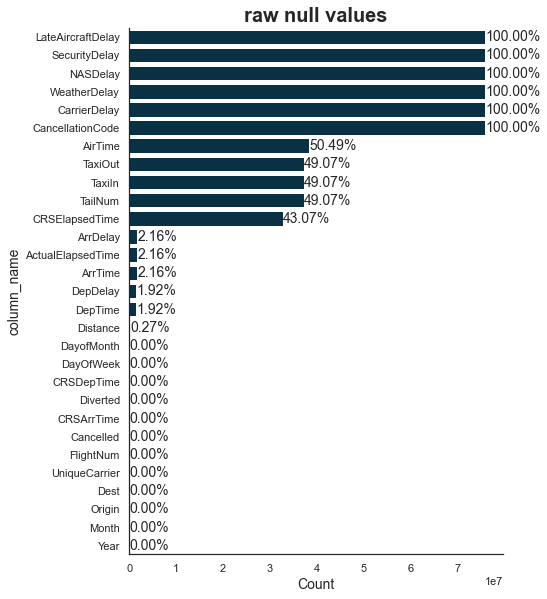

In [18]:
# Explore null values
nulls_df = explore_flights.explore_nulls(bar_chart=True)

In [19]:
# Display nulls_df
nulls_df

,column_name,raw
28,LateAircraftDelay,75900339
27,SecurityDelay,75900339
26,NASDelay,75900339
25,WeatherDelay,75900339
24,CarrierDelay,75900339
22,CancellationCode,75900339
13,AirTime,38319883
20,TaxiOut,37245646
19,TaxiIn,37245646
10,TailNum,37245646


In [20]:
# Load flights raw stream
flights_raw_stream_df = read_stream_raw(spark, flight_raw_path + os.sep + '*', schema=schema)

In [21]:
# Transform raw data and add metadata to it
flight_transformed_raw_df = transform_raw(flights_raw_stream_df, 'gharib_local_pc', 'Year')

In [22]:
# Create stream writer for raw data
flight_raw_writer = create_stream_writer(flight_transformed_raw_df,
                                         flight_bronz_checkpoint,
                                         'flight_raw_to_bronz',
                                         'p_Year')

In [23]:
# Start the stream writer
flight_raw_to_bronz = flight_raw_writer.start(flight_bronz_path)

In [24]:
# Check if the stream is active
flight_raw_to_bronz.isActive

True

In [26]:
# Display stream status
flight_raw_to_bronz.status

{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [27]:
# Wait until the stream is ready
until_stream_is_ready(spark, 'flight_raw_to_bronz')


The stream flight_raw_to_bronz is active and ready.


True

In [28]:
# Register the flights bronze table
register_delta_table(spark, 'flight_bronz', flight_bronz_path)

In [29]:
flights_bronze_df = spark.read.table('flight_bronz')

In [30]:
print(f'Number of rows in flights bronze table: {flights_bronze_df.count():,} rows')

Number of rows in flights bronze table: 75,900,339 rows


In [31]:
# Add bronze table to explore_flights class
explore_flights.add(flights_bronze_df, 'bronze')

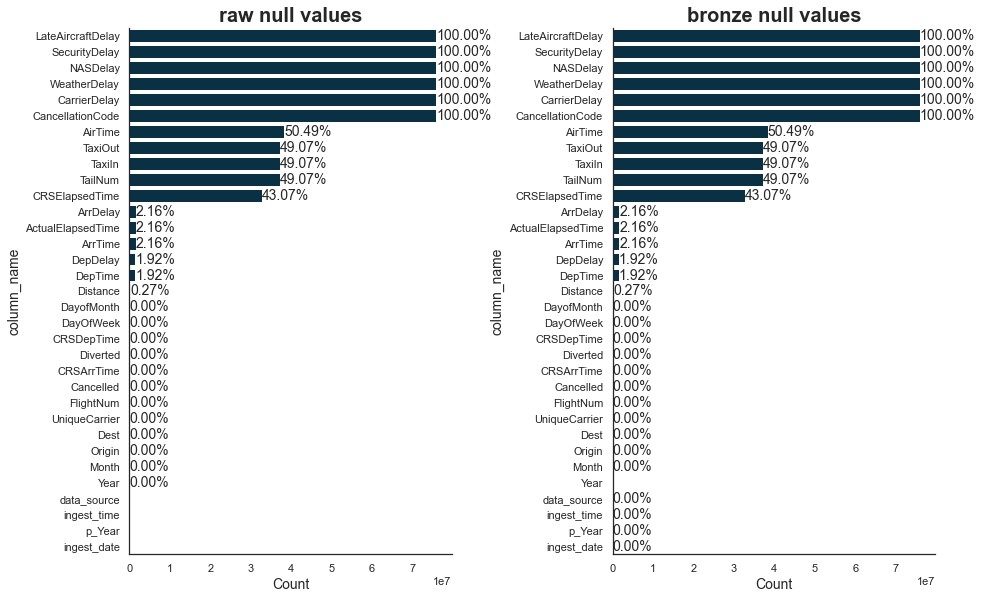

In [42]:
# Compare null values after transformation
nulls_df = explore_flights.explore_nulls(bar_chart=True)

In [43]:
# Display nulls_df
nulls_df

,column_name,raw,bronze,var_raw_bronze
0,LateAircraftDelay,75900339.0,75900339.0,0.0
1,SecurityDelay,75900339.0,75900339.0,0.0
2,NASDelay,75900339.0,75900339.0,0.0
3,WeatherDelay,75900339.0,75900339.0,0.0
4,CarrierDelay,75900339.0,75900339.0,0.0
5,CancellationCode,75900339.0,75900339.0,0.0
6,AirTime,38319883.0,38319883.0,0.0
7,TaxiOut,37245646.0,37245646.0,0.0
8,TaxiIn,37245646.0,37245646.0,0.0
9,TailNum,37245646.0,37245646.0,0.0


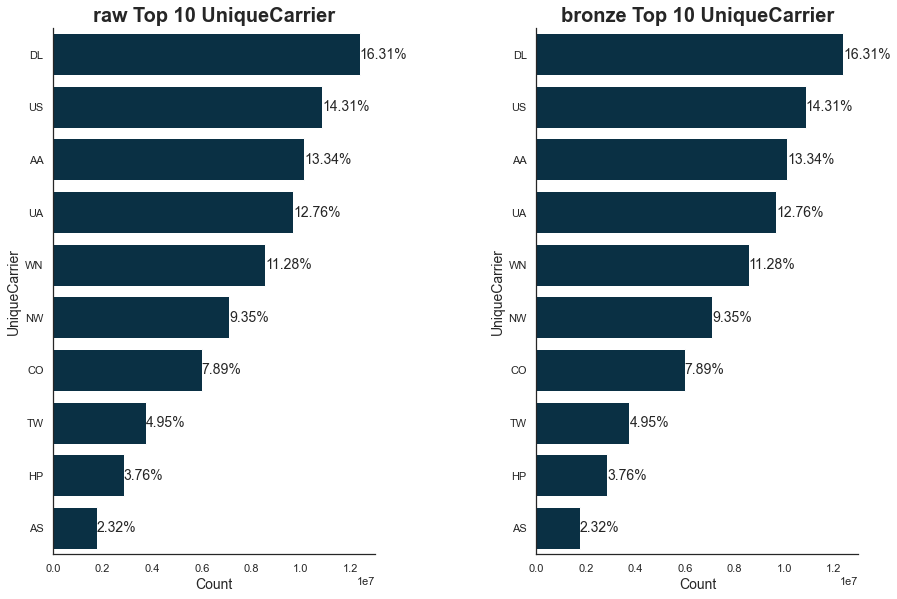

In [44]:
# Compare the top 10 uniqure carriers
top_10_uniqure_carriers = explore_flights.top_bottom_n('UniqueCarrier', top=True, n=10, bar_chart=True)

In [45]:
# Display the top 10 unique carriers df
top_10_uniqure_carriers

,UniqueCarrier,raw,bronze,var_raw_bronze
0,DL,12378649,12378649,0
1,US,10862502,10862502,0
2,AA,10125511,10125511,0
3,UA,9686718,9686718,0
4,WN,8564327,8564327,0
5,NW,7096960,7096960,0
6,CO,5990815,5990815,0
7,TW,3757747,3757747,0
8,HP,2857260,2857260,0
9,AS,1761450,1761450,0


In [46]:
# Read stream bronze table
flight_bronz_stream_df = read_stream_delta(spark, flight_bronz_path)

In [47]:
# Transfor bronze table
flight_bronz_transformed_df = transform_flight_bronz(flight_bronz_stream_df)

In [48]:
# Create stream writer
flight_bronz_writer = create_stream_writer(flight_bronz_transformed_df,
                                           flight_silver_checkpoint,
                                           'flight_bronz_to_silver',
                                           'p_Year')

In [51]:
# Start bronze to silver stream
flight_bronz_to_silver = flight_bronz_writer.start(flight_silver_path)

In [52]:
# Check if it is active
flight_bronz_to_silver.isActive

True

In [53]:
# Display status
flight_bronz_to_silver.status

{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [56]:
# Wait until it is ready
until_stream_is_ready(spark, 'flight_bronz_to_silver')

The stream flight_bronz_to_silver is active and ready.


True

In [57]:
# Register flight silver table
register_delta_table(spark, 'flight_silver', flight_silver_path)

In [58]:
flights_silver_df = spark.read.table('flight_silver')

In [59]:
print(f'Number of rows in flights bronze table: {flights_silver_df.count():,} rows')

Number of rows in flights bronze table: 75,900,339 rows


In [60]:
assert flights_silver_df.count() == flights_stream.rows_retrived, "number of rows retrived doesn't match"
print("Assertion passed.")

Assertion passed.


In [61]:
explore_flights.add(flights_silver_df, 'silver')

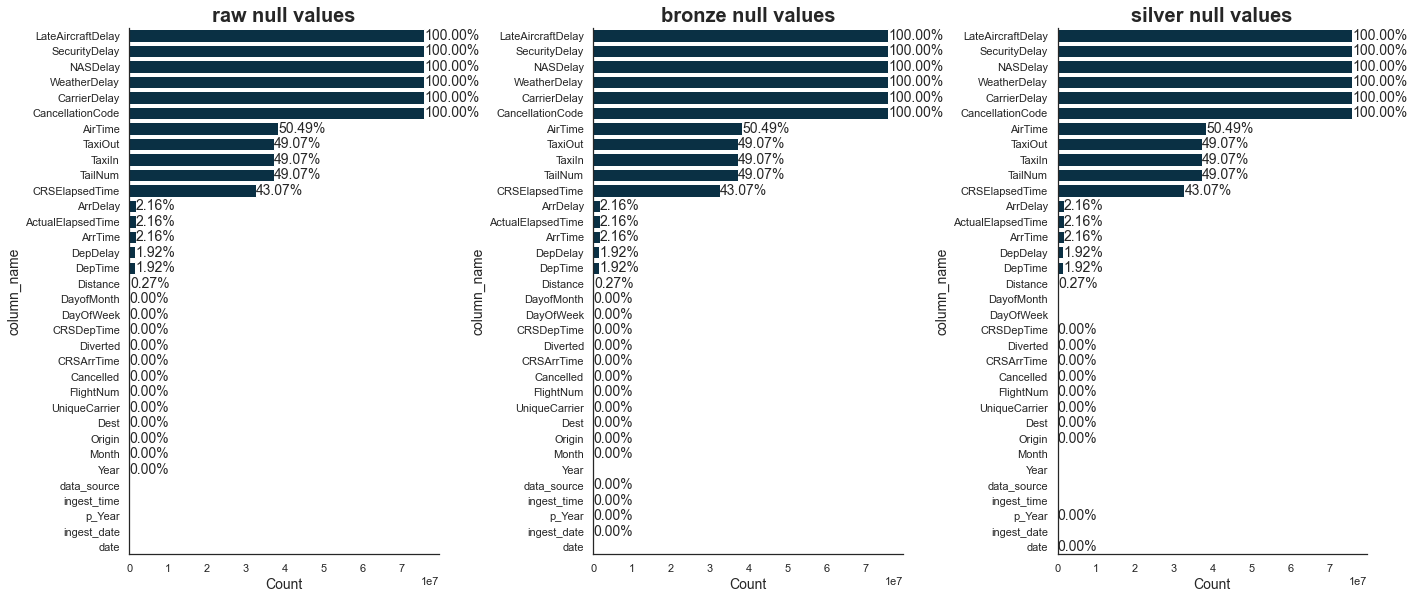

In [62]:
# Compare null values
nulls_df = explore_flights.explore_nulls(bar_chart=True)

In [63]:
# Display nulls df
nulls_df

,column_name,raw,bronze,silver,var_raw_bronze,var_raw_silver,var_bronze_silver
0,LateAircraftDelay,75900339.0,75900339.0,75900339.0,0.0,0.0,0.0
1,SecurityDelay,75900339.0,75900339.0,75900339.0,0.0,0.0,0.0
2,NASDelay,75900339.0,75900339.0,75900339.0,0.0,0.0,0.0
3,WeatherDelay,75900339.0,75900339.0,75900339.0,0.0,0.0,0.0
4,CarrierDelay,75900339.0,75900339.0,75900339.0,0.0,0.0,0.0
5,CancellationCode,75900339.0,75900339.0,75900339.0,0.0,0.0,0.0
6,AirTime,38319883.0,38319883.0,38319883.0,0.0,0.0,0.0
7,TaxiOut,37245646.0,37245646.0,37245646.0,0.0,0.0,0.0
8,TaxiIn,37245646.0,37245646.0,37245646.0,0.0,0.0,0.0
9,TailNum,37245646.0,37245646.0,37245646.0,0.0,0.0,0.0


#### Loading lookup tables into delta lake

In [64]:
plane_df = load_csv_to_dataframe(spark, l_plane_path)

In [65]:
transformed_plane_df = transform_lookup_plane(plane_df)

In [66]:
transformed_plane_df.write.format('delta').save(delta_lake + 'l_plane_silver')

In [67]:
register_delta_table(spark, 'l_plane_silver', delta_lake + 'l_plane_silver')
l_plan_df = spark.read.table('l_plane_silver')

In [68]:
airport_df = load_csv_to_dataframe(spark, l_airport_path)

In [69]:
transformed_airport_df = transform_lookup_airport(airport_df)

In [70]:
transformed_airport_df.write.format('delta').save(delta_lake + 'l_airport_silver')

In [71]:
register_delta_table(spark, 'l_airport_silver', delta_lake + 'l_airport_silver')
l_airport_df = spark.read.table('l_airport_silver')

In [72]:
cancelation_df = load_csv_to_dataframe(spark, l_cancelation_path)

In [73]:
cancelation_df.write.format('delta').save(delta_lake + 'l_cancelation_silver')

In [74]:
register_delta_table(spark, 'l_cancelation_silver', delta_lake + 'l_cancelation_silver')
l_cancelation_df = spark.read.table('l_cancelation_silver')

In [75]:
unique_carrier_df = load_csv_to_dataframe(spark, l_unique_carrier_path)

In [76]:
unique_carrier_df.write.format('delta').save(delta_lake + 'l_unique_carrier_silver')

In [77]:
register_delta_table(spark, 'l_unique_carrier_silver', delta_lake + 'l_unique_carrier_silver')
l_unique_carrier_df = spark.read.table('l_unique_carrier_silver')

### Step 3: Define the Data Model <a id='step3'></a>
#### 3.1 Conceptual Data Model
![Flights_Schema](images/Flights_Schema.png)

#### Connect to BI tools

Users can connect to the data model using power BI and the provided M function provided by the microsoft MVP Gerhard Brueckl [here](https://github.com/gbrueckl/connectors/blob/master/powerbi/fn_ReadDeltaTable.pq) </br> 
As you can see in the following screenshot

![PowerBI](images/PowerBI.png)

And they answer any question they want with the data like:
1. What is the main reason for delays.
2. what is the trend for the number of delayed flights by year.
3. When is the best time of day/day of week/time of year to fly to minimise delays?
4. Do older planes suffer more delays?
5. How does the number of people flying between different locations change over time?
6. How well does weather predict plane delays?
and too many other questions

#### 3.2 Mapping Out Data Pipelines
Refer to the flights flowchart above

### Step 4: Run Pipelines to Model the Data <a id='step4'></a>
#### 4.1 Create the data model
As we already build stream pipeline from raw to silver</br>
let's retrive the rest of the data

In [80]:
flights_stream.retrive(200, multiprocess=True)

  0%|                                                                                          | 0/240 [00:00<?, ?it/s]

Only 163 files left to retrive


Done... file: 2008: 100%|████████████████████████████████████████████████████████████| 240/240 [24:39<00:00,  2.36s/it]

In [81]:
# Save flight stream checkpoint
flights_stream.save()

Saved checkpoint at D:\1-Study\In-progress\DEND\flights-delta-lake\checkpoints\flight_raw\flight_raw.pickle


In [90]:
# Display stream status
flight_raw_to_bronz.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [94]:
# Display stream status
flight_bronz_to_silver.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [95]:
# Create lookup date table
create_or_update_date_table(spark, 'flight_silver', 'l_date_gold', date_gold_path)

Generating pandas dataframe for dates from 1987-01-01 to 2021-01-01
Converting pandas df to spark df and adding more features
Saving dim date delta table to D:\1-Study\In-progress\DEND\flights-delta-lake\delta_lake\date_gold
Registering date table with name l_date_gold in the metastore
Done...


In [96]:
date_gold_df = spark.read.table('l_date_gold')

In [97]:
# Create lookup date table
create_or_update_flight_gold(spark, 'flight_silver', 'flight_gold', flight_gold_path)

Saving flight_gold table to D:\1-Study\In-progress\DEND\flights-delta-lake\delta_lake\flight_gold
Registering date table with name flight_gold in the metastore
Done...


In [98]:
flights_gold_df = spark.read.table('flight_gold')

#### 4.2 Data Quality Checks
- Compare null values for flights bronze and silver
- Compare top 10 UniqueCarrier, origin, dest for all tables flights raw, bronze and silver
- Compare null values for lookup tables before and after transformations
- Compare null values for daily summary gold table
 
Run Quality Checks

In [106]:
# Intialize ExploreDfs class
explore_flights = ExploreDfs(flights_bronze_df, 'Bronze')
explore_flights.add(flights_silver_df, 'Silver')

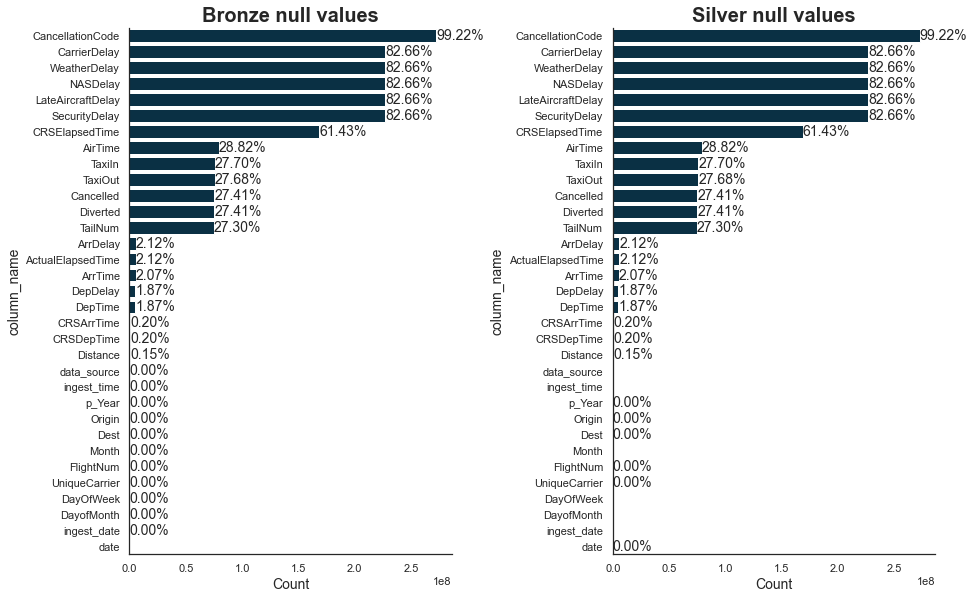

In [114]:
# Calculate nulls_df in all 3 dfs
nulls_df = explore_flights.explore_nulls(bar_chart=True)

In [108]:
# Display nulls_df
nulls_df 

,column_name,Bronze,Silver,var_Bronze_Silver
0,CancellationCode,272574759.0,272574759.0,0.0
1,CarrierDelay,227093795.0,227093795.0,0.0
2,WeatherDelay,227093795.0,227093795.0,0.0
3,NASDelay,227093795.0,227093795.0,0.0
4,LateAircraftDelay,227093795.0,227093795.0,0.0
5,SecurityDelay,227093795.0,227093795.0,0.0
6,CRSElapsedTime,168763173.0,168763173.0,0.0
7,AirTime,79183061.0,79183061.0,0.0
8,TaxiIn,76092404.0,76092404.0,0.0
9,TaxiOut,76039201.0,76039201.0,0.0


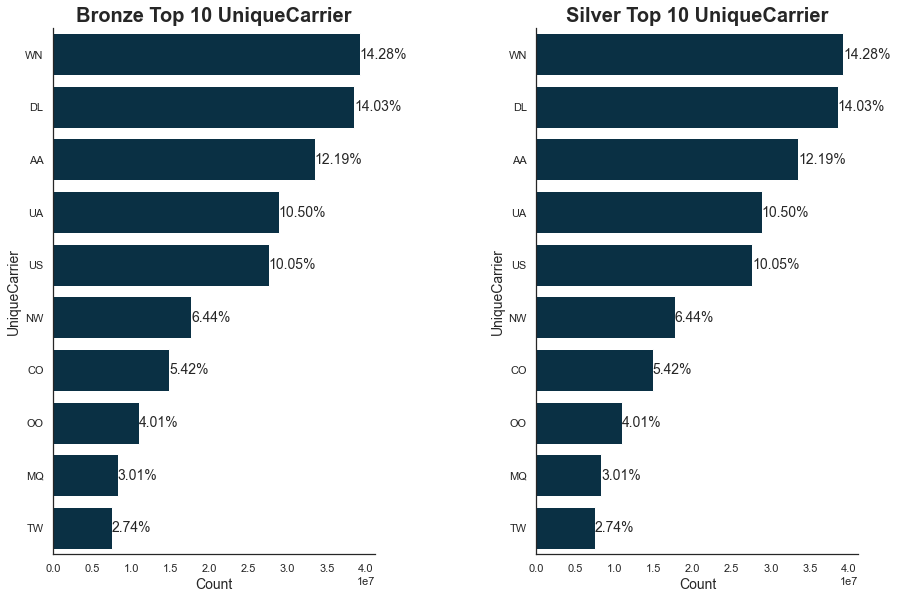

In [109]:
# Compare the top 10 Carriers
top_10_uniqure_carriers = explore_flights.top_bottom_n('UniqueCarrier', top=True, n=10, bar_chart=True)

In [110]:
# Display top 10 Carriers
top_10_uniqure_carriers

,UniqueCarrier,Bronze,Silver,var_Bronze_Silver
0,WN,39242087,39242087,0
1,DL,38549644,38549644,0
2,AA,33484367,33484367,0
3,UA,28852384,28852384,0
4,US,27597988,27597988,0
5,NW,17682720,17682720,0
6,CO,14879351,14879351,0
7,OO,11004563,11004563,0
8,MQ,8273768,8273768,0
9,TW,7515494,7515494,0


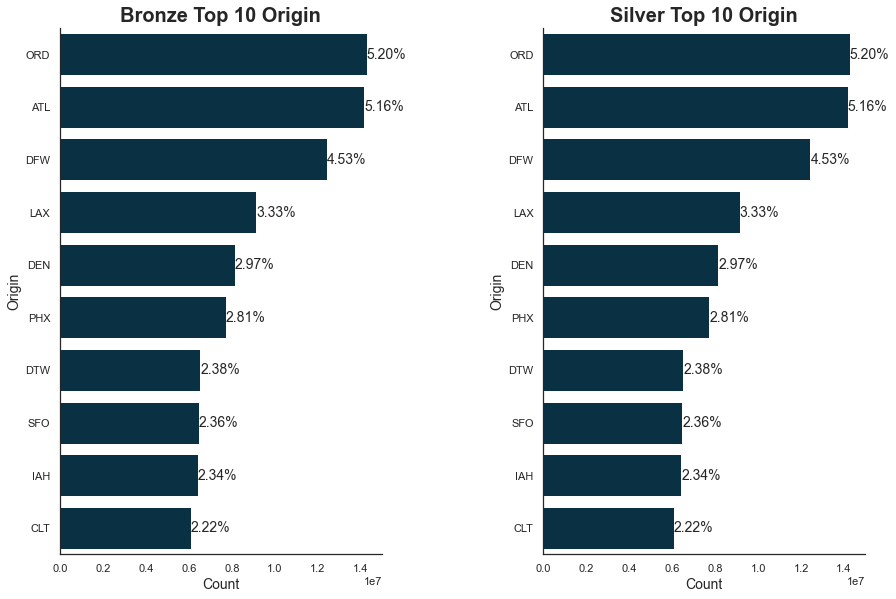

In [111]:
# Compare the top 10 Origin
top_10_origin = explore_flights.top_bottom_n('Origin', top=True, n=10, bar_chart=True)

In [112]:
# Display top 10 Origin
top_10_origin

,Origin,Bronze,Silver,var_Bronze_Silver
0,ORD,14272440,14272440,0
1,ATL,14163658,14163658,0
2,DFW,12435078,12435078,0
3,LAX,9142757,9142757,0
4,DEN,8150723,8150723,0
5,PHX,7733511,7733511,0
6,DTW,6526686,6526686,0
7,SFO,6474832,6474832,0
8,IAH,6430345,6430345,0
9,CLT,6086238,6086238,0


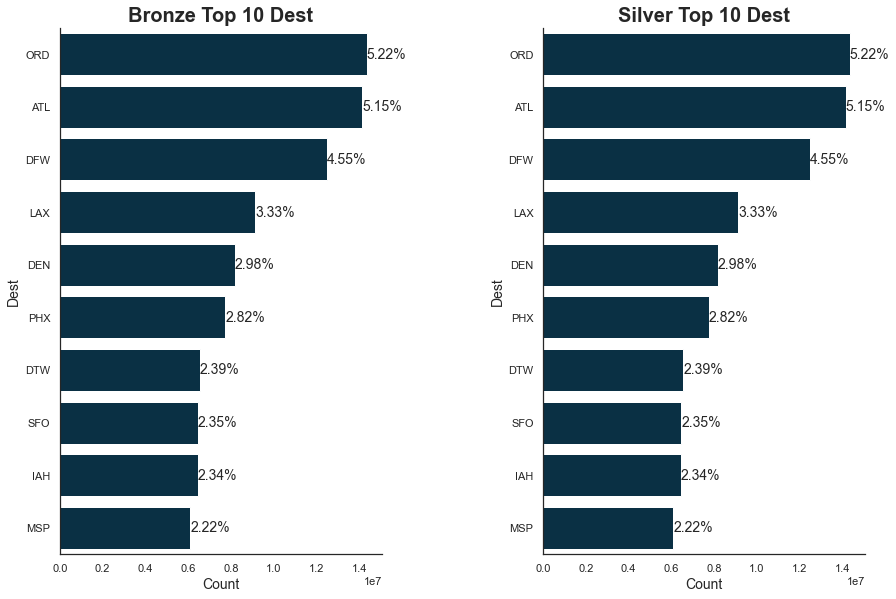

In [115]:
# Compare the top 10 Destination
top_10_destination = explore_flights.top_bottom_n('Dest', top=True, n=10, bar_chart=True)

In [116]:
# Display top 10 Destination
top_10_destination

,Dest,Bronze,Silver,var_Bronze_Silver
0,ORD,14353463,14353463,0
1,ATL,14158386,14158386,0
2,DFW,12504203,12504203,0
3,LAX,9138149,9138149,0
4,DEN,8181231,8181231,0
5,PHX,7746764,7746764,0
6,DTW,6562481,6562481,0
7,SFO,6458760,6458760,0
8,IAH,6441360,6441360,0
9,MSP,6101974,6101974,0


In [123]:
# Explore plane table before and after transformation
explore_plane = ExploreDfs(plane_df, 'Raw')
explore_plane.add(l_plan_df, 'Silver')
plane_nulls = explore_plane.explore_nulls(bar_chart=False)
# Display plane_nulls
plane_nulls

,column_name,Raw,Silver,var_Raw_Silver
0,type,549,0,549
1,manufacturer,549,0,549
2,issue_date,549,0,549
3,model,549,0,549
4,status,549,0,549
5,aircraft_type,549,0,549
6,engine_type,549,0,549
7,year,549,0,549
8,tailnum,0,0,0


In [124]:
# Explore airport table before and after transformation
explore_airport = ExploreDfs(airport_df, 'Raw')
explore_airport.add(l_airport_df, 'Silver')
airport_nulls = explore_airport.explore_nulls(bar_chart=False)
# Display airport_nulls
airport_nulls

,column_name,Raw,Silver,var_Raw_Silver
0,Code,0.0,NaN,NaN
1,Description,0.0,NaN,NaN
2,airport_name,NaN,6.0,NaN
3,country,NaN,1.0,NaN
4,airport_code,NaN,0.0,NaN
5,city,NaN,0.0,NaN


In [125]:
# Explore cancelation table before and after transformation
explore_cancelation = ExploreDfs(cancelation_df, 'Raw')
explore_cancelation.add(l_cancelation_df, 'Silver')
cancelation_nulls = explore_cancelation.explore_nulls(bar_chart=False)
# Display cancelation_nulls
cancelation_nulls

,column_name,Raw,Silver,var_Raw_Silver
0,Code,0,0,0
1,Description,0,0,0


In [126]:
# Explore unique carrier table before and after transformation
explore_unique_carrier = ExploreDfs(unique_carrier_df, 'Raw')
explore_unique_carrier.add(l_unique_carrier_df, 'Silver')
unique_carrier_nulls = explore_unique_carrier.explore_nulls(bar_chart=False)
# Display unique_carrier_nulls
unique_carrier_nulls

,column_name,Raw,Silver,var_Raw_Silver
0,Code,0,0,0
1,Description,0,0,0


In [127]:
# Explore date table
explore_date = ExploreDfs(date_gold_df, 'Gold')
date_nulls = explore_date.explore_nulls(bar_chart=False)
# Display date_nulls
date_nulls

,column_name,Gold
0,dte,0
1,year,0
2,quarter,0
3,month,0
4,day,0
5,dayofweek,0
6,dayofyear,0
7,weekofyear,0
8,month_short,0
9,month_name,0


In [128]:
# Explore daily summary gold table
explore_flight_gold = ExploreDfs(flights_gold_df, 'Gold')
flight_gold_nulls = explore_flight_gold.explore_nulls(bar_chart=False)
# Display flight_gold_nulls
flight_gold_nulls

,column_name,Gold
23,average_security_delay,5782
26,average_aircraft_delay,5722
17,average_weather_delay,5722
14,average_carrier_delay,5722
20,average_nas_delay,5722
3,total_diverted,4503
2,total_cancelled,4503
5,total_air_time,2649
4,avg_air_time,2649
8,average_dep_delay,1


#### 4.3 Data dictionary 
for this step we can add the data dictionary into the metadata for each table

In [136]:
flight_silver_dd = {
    "p_Year": "Year",
    "date": "date",
    "DepTime": "Actual Departure Time (local time: HH:mm)",
    "CRSDepTime": "CRS Departure Time (local time: HH:mm)",
    "ArrTime": "Actual Arrival Time (local time: HH:mm)",
    "CRSArrTime": "CRS Arrival Time (local time: HH:mm)",
    "UniqueCarrier": "Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years",
    "FlightNum": "Flight Number",
    "TailNum": "Tail Number",
    "ActualElapsedTime": "Elapsed Time of Flight, in Minutes",
    "CRSElapsedTime": "CRS Elapsed Time of Flight, in Minutes",
    "AirTime": "Flight Time, in Minutes",
    "ArrDelay": "Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers",
    "DepDelay": "Difference in minutes between scheduled and actual departure time. Early departures show negative numbers",
    "Origin": "Origin Airport",
    "Dest": "Destination Airport",
    "Distance": "Distance between airports (miles)",
    "TaxiIn": "Taxi In Time, in Minutes",
    "TaxiOut": "Taxi Out Time, in Minutes",
    "Cancelled": "Cancelled Flight Indicator (1=Yes)",
    "CancellationCode": "Specifies The Reason For Cancellation",
    "Diverted": "Diverted Flight Indicator (1=Yes)",
    "CarrierDelay": "Carrier Delay, in Minutes",
    "WeatherDelay": "Weather Delay, in Minutes",
    "NASDelay": "Weather Delay, in Minutes",
    "SecurityDelay": "Security Delay, in Minutes",
    "LateAircraftDelay": "Late Aircraft Delay, in Minutes"
}
add_comments_to_table(spark, 'flight_silver', flight_silver_dd)
spark.sql("""
DESCRIBE EXTENDED flight_silver
""").toPandas()

,col_name,data_type,comment
0,p_Year,int,Year
1,date,date,date
2,DepTime,string,Actual Departure Time (local time: HH:mm)
3,CRSDepTime,string,CRS Departure Time (local time: HH:mm)
4,ArrTime,string,Actual Arrival Time (local time: HH:mm)
5,CRSArrTime,string,CRS Arrival Time (local time: HH:mm)
6,UniqueCarrier,string,"Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years"
7,FlightNum,int,Flight Number
8,TailNum,string,Tail Number
9,ActualElapsedTime,int,"Elapsed Time of Flight, in Minutes"


In [138]:
flight_gold_dd = {
    "date": "date",
    "num_carriers": "Number of distinct carriers",
    "total_cancelled": "Total number of cancelled flights",
    "total_diverted": "Total number of diverted flights",
    "avg_air_time": "Average air time",
    "total_air_time": "Total air time",
    "count_dep_delay": "Number of delayed departute flights",
    "total_dep_delay": "Total delayed departure in minutes",
    "average_dep_delay": "Average delayed departure in minutes",
    "count_arr_delay": "Number of delayed arrival flights",
    "total_arr_delay": "Total delayed arrival in minutes",
    "average_arr_delay": "Average delayed arrival in minutes",
    "count_carrier_delay": "Number of delayed carrier flights",
    "total_carrier_delay": "Total delayed carrier in minutes",
    "average_carrier_delay": "Average delayed carrier in minutes",
    "count_weather_delay": "Number of delayed weather flights",
    "total_weather_delay": "Total delayed weather in minutes",
    "average_weather_delay": "Average delayed weather in minutes",
    "count_nas_delay": "Number delayed NAS flights",
    "total_nas_delay": "Total delayed NAS in minutes",
    "average_nas_delay": "Average delayed NAS in minutes",
    "count_security_delay": "Number of delayed security flights",
    "total_security_delay": "Total delayed security in minutes",
    "average_security_delay": "Average delayed security in minutes",
    "count_aircraft_delay": "Number of delayed aircraft flights",
    "total_aircraft_delay": "Total delayed aircraft in minutes",
    "average_aircraft_delay": "Average delayed aircraft in minutes",
    "total_distance": "Total distance",
    "average_distance": "Average distance",
    "num_flights": "Number of flights"
}
add_comments_to_table(spark, 'flight_gold', flight_gold_dd)
spark.sql("""
DESCRIBE EXTENDED flight_gold
""").toPandas()

,col_name,data_type,comment
0,date,date,date
1,num_carriers,bigint,Number of distinct carriers
2,total_cancelled,bigint,Total number of cancelled flights
3,total_diverted,bigint,Total number of diverted flights
4,avg_air_time,double,Average air time
5,total_air_time,bigint,Total air time
6,count_dep_delay,bigint,Number of delayed departute flights
7,total_dep_delay,bigint,Total delayed departure in minutes
8,average_dep_delay,double,Average delayed departure in minutes
9,count_arr_delay,bigint,Number of delayed arrival flights


In [140]:
date_gold_dd = {
    "dte": "date",
    "year": "year",
    "quarter": "quarter",
    "month": "month",
    "day": "day",
    "dayofweek": "day of week",
    "dayofyear": "day of year",
    "weekofyear": "week of year",
    "month_short": "month name short",
    "month_name": "month name",
    "month_year": "combined month and year in this format YYY-mmm",
    "sort_month_year": "integer month year for sorting",
    "quarter_year": "combined quarter and year in this format YYY-Q",
    "sort_quarter_year": "integer quarter year for sorting"
}
add_comments_to_table(spark, 'l_date_gold', date_gold_dd)
spark.sql("""
DESCRIBE EXTENDED l_date_gold
""").toPandas()

,col_name,data_type,comment
0,dte,date,date
1,year,int,year
2,quarter,string,quarter
3,month,int,month
4,day,int,day
5,dayofweek,int,day of week
6,dayofyear,int,day of year
7,weekofyear,int,week of year
8,month_short,string,month name short
9,month_name,string,month name


In [144]:
l_airport_dd = {
    "airport_code": "date",
    "airport_name": "year",
    "city": "quarter",
    "country": "month"
}
add_comments_to_table(spark, 'l_airport_silver', l_airport_dd)
spark.sql("""
DESCRIBE EXTENDED l_airport_silver
""").toPandas()

,col_name,data_type,comment
0,airport_code,string,date
1,airport_name,string,year
2,city,string,quarter
3,country,string,month
4,,,
5,# Partitioning,,
6,Not partitioned,,
7,,,
8,# Detailed Table Information,,
9,Name,flights_db.l_airport_silver,


In [146]:
l_cancelation_dd = {
    "Code": "Cancelation code A to D",
    "Description": "Cancelation reason description"
}
add_comments_to_table(spark, 'l_cancelation_silver', l_cancelation_dd)
spark.sql("""
DESCRIBE EXTENDED l_cancelation_silver
""").toPandas()

,col_name,data_type,comment
0,Code,string,Cancelation code A to D
1,Description,string,Cancelation reason description
2,,,
3,# Partitioning,,
4,Not partitioned,,
5,,,
6,# Detailed Table Information,,
7,Name,flights_db.l_cancelation_silver,
8,Location,file:/D:/1-Study/In-progress/DEND/flights-delta-lake/delta_lake/l_cancelation_silver,
9,Provider,delta,


In [147]:
l_unique_carrier_dd = {
    "Code": "Unique carier code",
    "Description": "Carier description",
}
add_comments_to_table(spark, 'l_unique_carrier_silver', l_unique_carrier_dd)
spark.sql("""
DESCRIBE EXTENDED l_unique_carrier_silver
""").toPandas()

,col_name,data_type,comment
0,Code,string,Unique carier code
1,Description,string,Carier description
2,,,
3,# Partitioning,,
4,Not partitioned,,
5,,,
6,# Detailed Table Information,,
7,Name,flights_db.l_unique_carrier_silver,
8,Location,file:/D:/1-Study/In-progress/DEND/flights-delta-lake/delta_lake/l_unique_carrier_silver,
9,Provider,delta,


In [151]:
l_plane_dd = {
   "tailnum": "Tail Number",
    "type": "Tyoe of the plane",
    "manufacturer": "Manufacturer",
    "issue_date": "Date of manufacturing",
    "model": "Model of the plane",
    "status": "Status of the plane (valid or not)",
    "aircraft_type": "Air craft type",
    "engine_type": "Engine Type",
    "year": "Year of manufacturing"
}
add_comments_to_table(spark, 'l_plane_silver', l_plan_dd)
spark.sql("""
DESCRIBE EXTENDED l_plane_silver
""").toPandas()

,col_name,data_type,comment
0,tailnum,string,Tail Number
1,type,string,Tyoe of the plane
2,manufacturer,string,Manufacturer
3,issue_date,string,Date of manufacturing
4,model,string,Model of the plane
5,status,string,Status of the plane (valid or not)
6,aircraft_type,string,Air craft type
7,engine_type,string,Engine Type
8,year,string,Year of manufacturing
9,,,


#### Step 5: Complete Project Write Up <a id='step5'></a>
* Clearly state the rationale for the choice of tools and technologies for the project.</br>
    As mentioned in the project scop delta lake is new technology brings the best of Data lake and Data warehouses 
* Propose how often the data should be updated and why.
    The data should be updated monthly as the source provide them
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     We can deploy our model to the cloude and scale up
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     We can schadule the stream to run everyday at 4am  
 * The database needed to be accessed by 100+ people.
     Delta lake can handle as many users with no issues